# Labeling videos
* Manually going through every frame of the video
* Selecting numbers 0-4 every frame based on the amount of lights turned on in the frame
* Based on the selected number, the frame will be saved with the following naming format: 
    * [name of the video]\_[the sequence of the frame]\_[amount of visible lights].jpg

In [1]:
import cv2
import os

# Function to label frames manually
def label_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)

    video_name = video_path.split('/')[-1]

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    current_frame = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        # Display the frame and get user input
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(0) & 0xFF

        # amount of lights turned on
        if key == ord('0'):
            label = '0'
        elif key == ord('1'):
            label = '1'
        elif key == ord('2'):
            label = '2'
        elif key == ord('3'):
            label = '3'
        elif key == ord('4'):
            label = '4'
        elif key == ord('q'):
            break
        else:
            label = 'skip'

        # Save the labeled frame
        frame_filename = os.path.join(output_folder, f"{video_name}_{current_frame:05d}_{label}.jpg")
        cv2.imwrite(frame_filename, frame)

        current_frame += 1

        # Break the loop if all frames are labeled
        if current_frame == frame_count:
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage
video_path = './vidscapstone/test.mp4'
output_folder = 'labeled_frames_test'

label_frames(video_path, output_folder)

# Loading frames
* The images (frames) are all read and put in an array, along with the corresponding label
* The label is whatever amount of lights are turned on in the current frame
* The label is taken from the last part of the image name
* To get a dataset with no overrepresented values, labels 2 and 4 are limited to 30 occurences
* The dataset is created to train and test with

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
from glob import glob
import cv2
import numpy as np

# Load labeled frames and their corresponding labels
def load_labeled_frames(data_folder):
    images = []
    labels = []

    label_2_count = 0
    label_4_count = 0

    for image_path in glob(os.path.join(data_folder, '*.jpg')):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (100, 100))

        label = os.path.splitext(os.path.basename(image_path))[0].split('_')[-1]


        if (label_4_count < 30 or label != '4') and (label_2_count < 30 or label != '2'):
            images.append(image)

        if label == '0':
            labels.append(0)
        elif label == '1':
            labels.append(1)
        elif label == '2':
            if label_2_count < 30:
                labels.append(2)
                label_2_count += 1
        elif label == '3':
            labels.append(3)
        elif label == '4':
            if label_4_count < 30:
                labels.append(4)
                label_4_count += 1

    return images, labels

# Preprocess the data
def preprocess_data(images, labels):
    images = np.array(images)
    labels = np.array(labels)

    # Normalize pixel values to be between 0 and 1
    images = images / 255.0

    # Shuffle and split the data into training and testing sets
    images, labels = shuffle(images, labels, random_state=46)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=45)

    return X_train, X_test, y_train, y_test

# Setup
* The functions to create the dataset are called
* Due to a small dataset, the dataset is duplicated
* The y-values are converted to categorical data, instead of numerical data

In [9]:
import tensorflow as tf

# Example usage
output_folder = 'labeled_frames'
output_folder2 = 'labeled_frames_test'

# Load labeled frames and their corresponding labels
images, labels = load_labeled_frames(output_folder)
images2, labels2 = load_labeled_frames(output_folder2)

# images = images * 2
# labels = labels * 2

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(images, labels)

input_shape = X_train[0].shape

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=5)



# Bar plot with balanced data

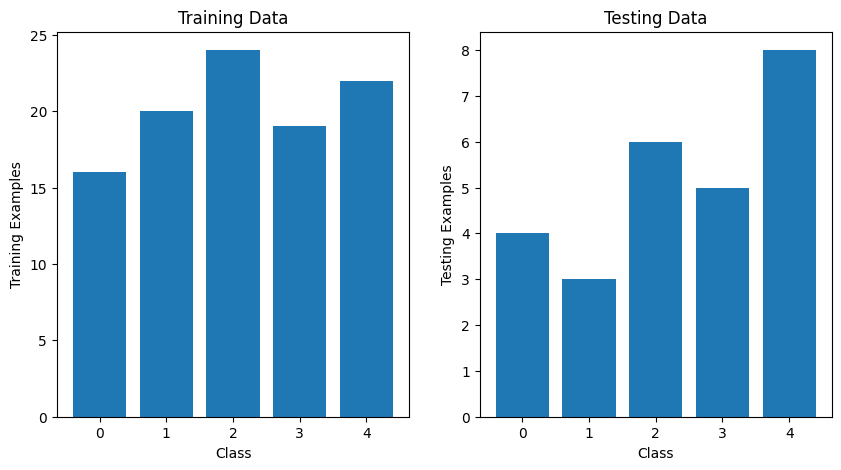

In [10]:
# Bar plots of the number of training and testing examples for each class
import matplotlib.pyplot as plt
import numpy as np

# Count the number of training and testing examples for each class
train_counts = np.bincount(y_train_one_hot.argmax(axis=1))
test_counts = np.bincount(y_test_one_hot.argmax(axis=1))

# Plot bar plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(5), train_counts)
plt.xticks(np.arange(5))
plt.xlabel('Class')
plt.ylabel('Training Examples')
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.bar(np.arange(5), test_counts)
plt.xticks(np.arange(5))
plt.xlabel('Class')
plt.ylabel('Testing Examples')
plt.title('Testing Data')

plt.show()

# Model creation and training
* Model is created with the necessary layers
* Five Softmax neurons for the 5 available categories
* Compiled with the Adam optimizer
* Trained on  10 epochs
* Training history is saved

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Build the model
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use categorical crossentropy for multiclass classification
              metrics=['accuracy', 'AUC', 'MeanSquaredError'])

# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=10, validation_data=(X_test, y_test_one_hot))



Epoch 1/10
4/4 [==============================] - 5s 859ms/step - loss: 1.5704 - accuracy: 0.4653 - auc: 0.7394 - mean_squared_error: 0.1568 - val_loss: 1.3779 - val_accuracy: 0.6538 - val_auc: 0.8872 - val_mean_squared_error: 0.1395
Epoch 2/10
4/4 [==============================] - 2s 505ms/step - loss: 1.2066 - accuracy: 0.7129 - auc: 0.9372 - mean_squared_error: 0.1212 - val_loss: 0.9793 - val_accuracy: 0.6538 - val_auc: 0.9003 - val_mean_squared_error: 0.0989
Epoch 3/10
4/4 [==============================] - 2s 503ms/step - loss: 0.7111 - accuracy: 0.7228 - auc: 0.9515 - mean_squared_error: 0.0691 - val_loss: 0.7897 - val_accuracy: 0.8077 - val_auc: 0.9229 - val_mean_squared_error: 0.0782
Epoch 4/10
4/4 [==============================] - 2s 487ms/step - loss: 0.3415 - accuracy: 0.9406 - auc: 0.9912 - mean_squared_error: 0.0347 - val_loss: 0.5033 - val_accuracy: 0.9231 - val_auc: 0.9560 - val_mean_squared_error: 0.0370
Epoch 5/10
4/4 [==============================] - 2s 446ms/step 

# Saving the necessary values

In [12]:
import pickle

directory = 'testing_multiclass_classification/'

model.save(directory + 'testing_multiclass_classification_model_Adam.h5')

with open(directory + 'testing_multiclass_classification_model_Adam_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

with open(directory + 'testing_multiclass_classification_model_Adam_X_test', 'wb') as file_pi:
    pickle.dump(X_test, file_pi)

with open(directory + 'testing_multiclass_classification_model_Adam_y_test', 'wb') as file_pi:
    pickle.dump(y_test_one_hot, file_pi)

C:\Users\diren\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
import cv2
import numpy as np
import tensorflow as tf
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

# Load the pre-trained model and label map
model_path = 'path/to/your/model'
label_map_path = 'path/to/your/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(label_map_path, use_display_name=True)
detection_model = tf.saved_model.load(model_path)

# Process a sample frame
video_path = 'path/to/your/video.mp4'
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Convert the frame to a TensorFlow tensor
input_tensor = tf.convert_to_tensor(frame[tf.newaxis, ...])

# Make predictions
detections = detection_model(input_tensor)

# Visualize the detections (optional)
vis_util.visualize_boxes_and_labels_on_image_array(
    frame,
    np.squeeze(detections['detection_boxes'].numpy()),
    np.squeeze(detections['detection_classes'].numpy()).astype(np.int32),
    np.squeeze(detections['detection_scores'].numpy()),
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,  # You can adjust this parameter based on your requirements
    min_score_thresh=0.3,  # You can adjust this threshold based on your requirements
    agnostic_mode=False,
)

# Display the visualized frame (optional)
cv2.imshow('Object Detection', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get the number of ROIs for this frame
num_rois = len(np.squeeze(detections['detection_boxes'].numpy()))
print(f'Number of ROIs: {num_rois}')


ModuleNotFoundError: No module named 'object_detection'